In [3]:
''' Simulation of 2D Ising model. Tested on Python 3.10.6'''

' Simulation of 2D Ising model. Tested on Python 3.10.6'

## Introduction

Here I am going to present a project, simulating the 2D Ising model using Monte Carlo Simulation. 

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

The problem itself is defined on an $L = 10 \times 10 $grid, with a 100 spins pointing either up or down. The distribution of the spins on the grid is random, or all spins points upwards. I have defined a function, called __plotspins__, which visualize the grid

In [5]:
def plotspins(M,mode):
    plt.figure(figsize=(6,6))
    values = np.unique(M.ravel())
    
    im = plt.imshow(M, interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label="Spin {l}".format(l=values[i]) ) for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    if(mode==1):
        plt.title('Randomozed sipns on grid')
    elif(mode==2):
        plt.title('Lattice after simulation')
    plt.grid(True)
    plt.xticks(ticks=np.linspace(0,9,10))
    plt.yticks(ticks=np.linspace(0,9,10))
    plt.show()

In [6]:

def initgrid(L = 10, allup=False, ifplot=True):

    M=np.zeros([L,L])
    for i in range(len(M)):
        for j in range(len(M)):
            ran=np.random.random()
            if(ran<0.5):
                M[i,j] = 1
            else:
                if allup==False:
                    M[i,j] = -1
                else:
                    M[i,j] = 1
    if ifplot == True:
        plotspins(M,1)
    return M, L

To calculate __M__, the magnetisation, sum up all the spins and divide with the 'volume'

In [7]:
def calcMagnetization(M):
    spin = 0
    spin=np.sum(M)
    return spin/len(M)**2

I also wanted the model to stop after the quantities are not changing anymore relative to the average of the previous cycles.

In [8]:
def earlystopping(array, delta, index):
    index=index+index % 30
    data=np.array(array[index-index/10:])
    ave1=np.average(data)
    data2=np.array(array[index-index/30:])
    ave2=np.average(data2)
    if abs((ave2-ave1))<ave1/50:
        return True
    else:
        return False
    

I also needed a function to calculate the energy change for a given spin-flip.

In [9]:
def deltaE(S0, Sn, J, H):

  return 2 * S0 * (H + J * Sn)

The Hamiltonian for the Ising model is:
$$ H(\vec{\sigma}) = - J \sum_{<ij>} \sigma_i \sigma_j -h \sum_i \sigma_i$$ 
$J$ is the interaction strength and $h$ is the external magnetic field.<br>
Furthermore,
$$ P(\vec{\sigma}) = \dfrac{e^{-\beta H(\vec{\sigma})}}{Z} $$
where the partition function, Z is:
$$ Z = \sum_{ \{ \vec{\sigma} \} } e^{-\beta H(\vec{\sigma})}. $$





In [10]:
def isingmodel (
    n = 100,
    h = 1,
    K = 1, 
    kbT = 5,
    L = 10,
    M = np.zeros(10),
):
    
    Energy = 0
    for i in range(L):
        for j in range (L):
            Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L]   
            Energy -= M[i,j]*(h+K*Sn)
    magnetization = []
    Energy=Energy/2
    energyHistory = []
    max=0
    
    for tstep in range(n):
        
        i=np.random.randint(10)
        j=np.random.randint(10)
        
        Sn = M[(i - 1) % L, j] + M[(i + 1) % L, j] + M[i, (j - 1) % L] + M[i, (j + 1) % L]
        
        dE= deltaE(M[i, j], Sn, K, h)
        
        if dE<0 or np.random.random()<np.exp(-dE/kbT):
            Energy+=dE
            M[i,j]=-1*M[i,j]
            
        energyHistory.append(Energy)
        magnetization.append(calcMagnetization(M)) 
        '''
        if tstep>100:
            if earlystopping(magnetization,0.1,tstep) == True:
                max=tstep
                break
    '''
    if max == 0:
        max=n
    numofave=int(max/10)
    return energyHistory, np.average(np.array(energyHistory[max-numofave:])) ,M, max, magnetization, np.average(np.array(magnetization[max-numofave:]))


        

Now that the model is defined, lets see an example.

Initialize Grid...


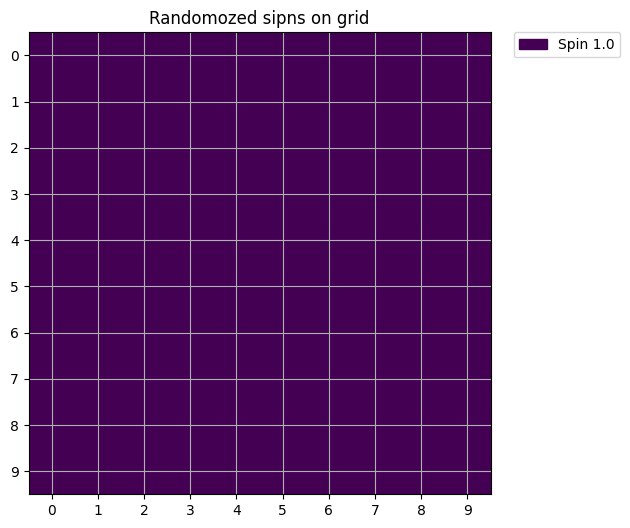

Grid initialized!
Start simulation...
Simulation successful!


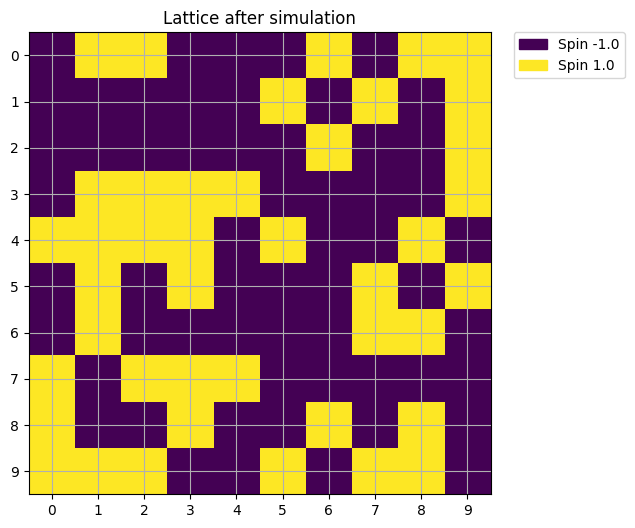

In [11]:
print('Initialize Grid...')
M, L = initgrid(10,True, True)
print('Grid initialized!')
print('Start simulation...')
Earr, Eave, Spins, steps, Marr, Mave = isingmodel(5000,0,-0.1,1,10,M)
print('Simulation successful!')
plotspins(Spins,2)


Visualize energy, magnetization:

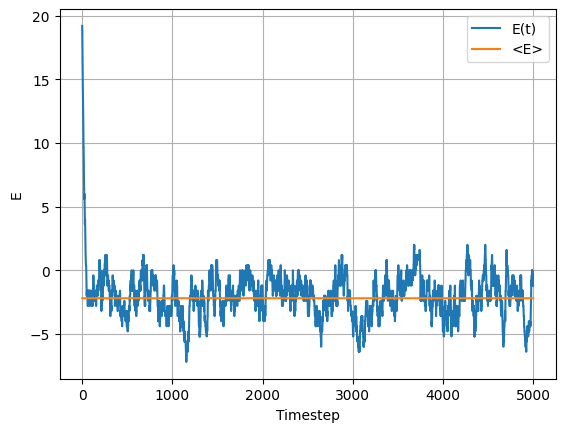

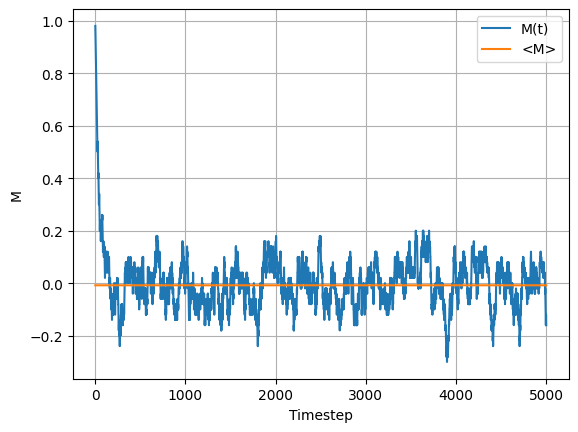

In [12]:
plt.plot(np.linspace(1,steps,steps), Earr,np.linspace(1,steps,steps), np.linspace(1,1,steps)*Eave)
plt.legend({'E(t)','<E>'})
plt.ylabel('E')
plt.xlabel('Timestep')
plt.grid(True)
plt.show()
plt.plot(np.linspace(1,steps,steps), Marr,np.linspace(1,steps,steps), np.linspace(1,1,steps)*Mave)
plt.ylabel('M')
plt.legend({'M(t)','<M>'})
plt.xlabel('Timestep')
plt.grid(True)
plt.show()

In [15]:
ave = [] #Array for the average magnetization
H = []  #Array for the corresponding external field
for i in range(100):
    Grid, L = initgrid(10,True, False) #Init grid with all spins up
    h = np.random.random()*20-10 # Randomly select the external field in h=[-10, 10]
    Earr,Eave,Spins,steps, Marr, Mave = isingmodel(50000,h,1,5,10,M) #Monte Carlo simulation
    ave.append(Mave)
    H.append(h) 

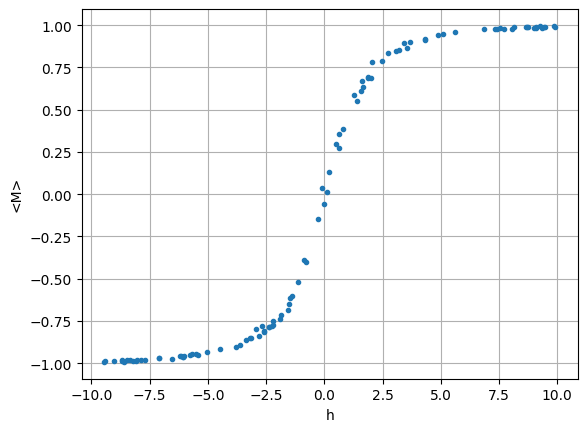

In [19]:
plt.plot(H,ave,'.')
plt.xlabel('h')
plt.ylabel('<M>')
plt.grid(True)

# Discussion
* Large *h* means large external field, which makes the spins orient in the same direction, i.e. $\lim(M)_{h->{\infty}} = 1$.
* With opposite *h*, the opposite orientation occurs (even function), and $\lim(M)_{h->{-\infty}} = -1$.
* At *h=0*, the interaction term dominates, resulting in $M=0$ (as many up spins as down).

# Susceptibility


In [ ]:
def susceptibility(M,kbT):
    data= np.array(M)
    return (np.std(data))**2/kbT

In [ ]:
H=[]
ave=[]
es=0
derivative=[]
hi=[]
delta=0.01
#numrical method to approximate the derivative
for i in range(10):
    h=np.random.random()*0.01-0.005
    Data,M,n, magn,average=isingmodel(500000,h+delta,1,2)
    Data,M,n, magn1,H0=isingmodel(500000,h-delta,1,2)
    es+=1
    derivative.append((average-H0)/(2*delta))
    hi.append(susceptibility(magn[n-1500:],1))
    ave.append(average)
    H.append(h)
plt.plot(H,derivative,'.')



NameError: name 'np' is not defined

In [ ]:
num=0
sum=0
for i in range(len(derivative)):
    if derivative[i]<50 and derivative[i] >-50:
        num+=1
        sum+=derivative[i]

In [ ]:
print(derivative)

[0.24359999999999382, 91.84904, 0.0012399999999967992, 1.3362799999999952, 92.30066000000001, -0.4200999999999899, -0.6250600000000051, -0.22157999999999345, -0.5208600000000063, 0.5589199999999905]


In [ ]:
sum/num

0.04405499999999771